# Advent of Code 2021
Here are my solutions to [Advent of Code](https://adventofcode.com/2021) using a Jupyter Notebook.

I kept pretty much on track until day 19, which was fiddly.

I needed a hint for day 22 and didn't get round to day 24 until now.

![all done](done.png)

In [1]:
# Let's import some standard modules
import collections as cs
import itertools as its
import operator as ops
import copy
import functools
import math
import random
import re
import statistics

In [2]:
# And some non-standard modules
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Here are some useful helpers
def day(day):
    'Load the input for `day`'
    return open(f'input/{day}').read()

def ints(s):
    'Return a tuple of integer tokens in `s`'
    return tuple(int(x) for x in re.findall(r'[-+]?\d+', s))

def overlapping(xs, n):
    '''Generate overlapping n-tuples from `xs`

    overlapping('ABCDEFG', 3) --> ABC BCD CDE DEF EFG
    '''
    if isinstance(xs, cs.abc.Sequence):
        yield from (xs[i:i+n] for i in range(len(xs) + 1 - n))
    else:
        result = cs.deque(maxlen=n)
        for x in xs:
            result.append(x)
            if len(result) == n:
                yield tuple(result)
                
def pairwise(iterable):
    's -> (s0,s1), (s1,s2), (s2, s3), ...'
    return overlapping(iterable, 2)

def atoms(text):
    'Return the tuple of atoms in the supplied text'
    return tuple(map(atom, text.split()))

def atom(s):
    'Parse text into a single float or int or str'
    try:
        v = float(s)
        return round(v) if round(v) == v else v
    except ValueError:
        return s

def transpose(rows):
    return tuple(zip(*rows))

def last(xs):
    'Return the last element of an iterable sequence'
    return cs.deque(iter(xs), maxlen=1)[0]

def nth(xs, n):
    'Return the nth element of a sequence.'
    return next(its.islice(xs, n, None))

def neighbours4(c, limits=None):
    'Return horizontal and vertical neighbours of c, a complex number'
    ns = c-1j, c+1, c+1j, c-1
    return {n for n in ns if limits is None or n in limits}

def neighbours8(c, limits=None):
    'Return neighbours of c, a complex number'
    ns = c-1j,c+1,c+1j,c-1,c+1+1j,c+1-1j,c-1+1j,c-1-1j
    return {n for n in ns if limits is None or n in limits}

flatten = its.chain.from_iterable
first = next
cat = ''.join
ncat = '\n'.join

## Day 1: [Sonar Sweep](https://adventofcode.com/2021/day/1)
The input is a sequence of depth measurements, and we're asked to count the number of measuments which exceed their predecessor.

In [4]:
depths = ints(day(1))
sum(n > p for p, n in pairwise(depths))

1564

For part two, we're asked to consider a 3-measurement sliding window. We want the number of times the summed values in this window increases. Notice that each time the window slides forward, one value is dropped and one value is added: we can get our answer by comparing these values.

In [5]:
sum(n > p for p, n in zip(depths, depths[3:]))

1611

## Day 2: [Dive!](https://adventofcode.com/2021/day/2)
We are given a sequence of instructions for moving a submarine.

In [6]:
example_2 = '''\
forward 5
down 5
forward 8
up 3
down 8
forward 2
'''

def dive(instructions):
    pos, depth = 0, 0
    for step, value in map(atoms, instructions.splitlines()):
        if step == 'forward': pos += value
        elif step == 'down': depth += value
        else: assert step == 'up'; depth -= value
    return pos * depth

assert dive(example_2) == 150
dive(day(2))

1690020

Part 2 reinterprets the instructions:
- down X increases your aim by X units.
- up X decreases your aim by X units.
- forward X does two things:
  - It increases your horizontal position by X units.
  - It increases your depth by your aim multiplied by X.

In [7]:
def dive(instructions):
    pos, depth, aim = 0, 0, 0
    for step, value in map(atoms, instructions.splitlines()):
        if step == 'forward': pos += value; depth += aim * value
        elif step == 'down': aim += value
        else: assert step == 'up'; aim -= value
    return pos * depth

assert dive(example_2) == 900
dive(day(2))

1408487760

## Day 3: [Binary Diagnostic](https://adventofcode.com/2021/day/3)
We have a series of binary numbers. The gamma rate is an accumulation of these numbers, being the most common digit in each column. The epsilon rate is the least common digit in each column. The power consumption is the product of these two rates.


In [8]:
example_3 = '''\
00100
11110
10110
10111
10101
01111
00111
11100
10000
11001
00010
01010
'''

def power_consumption(rows):
    m = len(rows)//2
    more_ones = [col.count('1') > m for col in transpose(rows)]
    gamma   = cat('01'[v] for v in more_ones)
    epsilon = cat('10'[v] for v in more_ones)
    return int(gamma, 2) * int(epsilon, 2)

assert power_consumption(example_3.splitlines()) == 198
power_consumption(day(3).splitlines())

1131506

Part two asks us to calculate another product from the list of binary numbers. This time we reduce the set of numbers by applying a bit criteria until we are left with a single number. For the oxygen rating, we determine the most common value (0 or 1) in the current bit position, and keep only numbers with that bit in that position, where bit positions are 0, 1, ... The CO2 rating is similar but filters on the least common value.

In [9]:
def rating(xs, w, bit_criteria):
    "Calculate the rating of binary numbers `xs`, bitwidth `w`"
    for c in range(w):
        ones = {x for x in xs if x[c]=='1'}
        zeros = xs - ones
        xs = bit_criteria(zeros, ones)
        if len(xs) == 1:
            return xs.pop()

def life_support_rating(rows):
    w = len(rows[0])
    O_rating   = rating(set(rows), w, lambda zeros, ones: max(ones, zeros, key=len))
    CO2_rating = rating(set(rows), w, lambda zeros, ones: min(zeros, ones, key=len))
    return int(O_rating, 2) * int(CO2_rating, 2)

assert life_support_rating(example_3.splitlines()) == 230
life_support_rating(day(3).splitlines())

7863147

## Day 4: [Giant Squid](https://adventofcode.com/2021/day/4)
The input is a sequence of numbers followed by a list of 5x5 bingo cards. For part one, we must calculate a score for the winning board.

In [10]:
example_4 = '''\
7,4,9,5,11,17,23,2,0,14,21,24,10,16,13,6,15,25,12,22,18,20,8,19,3,26,1

22 13 17 11  0
 8  2 23  4 24
21  9 14 16  7
 6 10  3 18  5
 1 12 20 15 19

 3 15  0  2 22
 9 18 13 17  5
19  8  7 25 23
20 11 10 24  4
14 21 16 12  6

14 21 17 24  4
10 16 15  9 19
18  8 23 26 20
22 11 13  6  5
 2  0 12  3  7
'''

In [11]:
def load_bingo_game(data):
    rows = data.splitlines()
    numbers = ints(rows[0])
    cards = [[ints(r) for r in rows[s:s+5]] for s in range(2, len(rows), 6)]
    return numbers, cards

def card_score(card, drawn, last_drawn):
    "Return bingo card score = sum of unmarked numbers x last number drawn"
    unmarked = set(flatten(card)) - drawn
    return sum(unmarked) * last_drawn    

def bingo(card, drawn):
    return (   any(set(row) <= drawn for row in card) 
            or any(set(col) <= drawn for col in transpose(card)))

def winning_score(numbers, cards):
    drawn = set()
    players = range(len(cards))

    for number in numbers:
        drawn.add(number)
        p = next((p for p in players if bingo(cards[p], drawn)), None)
        if p is not None:
            return card_score(cards[p], drawn, number)

assert winning_score(*load_bingo_game(example_4))
winning_score(*load_bingo_game(day(4)))

50008

For part two, we're asked for the winning score for the last board to win. I changed my solution to part one to generate a sequence of winning scores.

In [12]:
def winning_scores(numbers, cards):
    drawn = set()
    players = set(range(len(cards)))

    for number in numbers:
        drawn.add(number)
        winners = {p for p in players if bingo(cards[p], drawn)}
        yield from (card_score(cards[w], drawn, number) for w in winners)
        players -= winners

assert first(winning_scores(*load_bingo_game(example_4))) == 4512
assert  last(winning_scores(*load_bingo_game(example_4))) == 1924
last(winning_scores(*load_bingo_game(day(4))))

17408

## Day 5: [Hydrothermal Venture](https://adventofcode.com/2021/day/5)
The input is a list of line segments in the 2D plane in the format `x1,y1 -> x2,y2`. For part one we consider horizontal and vertical lines only, and must count the number of points where at least two points overlap.


In [13]:
example_5 = '''\
0,9 -> 5,9
8,0 -> 0,8
9,4 -> 3,4
2,2 -> 2,1
7,0 -> 7,4
6,4 -> 2,0
0,9 -> 2,9
3,4 -> 1,4
0,0 -> 8,8
5,5 -> 8,2
'''

def axis_aligned(x, y, X, Y):
    return x == X or y == Y

def span(a, b):
    d = 1 if a < b else -1
    return its.repeat(a) if a == b else range(a, b+d, d)

def segment_points(x, y, X, Y):
    "Return grid points on the axis aligned or diagonal segment"
    return zip(span(x, X), span(y, Y))

def points_covered(segs, accept):
    """Return grid pt counts for pts covered by segments.
    accept(seg) => True if seg should be included, False otherwise
    """
    return cs.Counter(
        p for seg in map(ints, segs.splitlines())
        if accept(*seg) for p in segment_points(*seg))

def multiply_covered(segs, accept):
    return sum(n > 1 for n in points_covered(segs, accept).values())

assert multiply_covered(example_5, axis_aligned) == 5
multiply_covered(day(5), axis_aligned)

6564

For part two, we are told the input segments are horizontal, vertical, or a 45 degrees diagonal, and again we're asked to count multiply covered points.
I revisited the solution to part one and added code to:
- handle diagonal segments
- filter which segments are counted

In [14]:
assert multiply_covered(example_5, lambda *v: True) == 12
multiply_covered(day(5), lambda *v: True)

19172

## Day 6: [Lanternfish](https://adventofcode.com/2021/day/6)
Every 7 days, a laternfish spawns a new lanternfish. The new laternfish starts with a count of 8. How many lanternfish are there after a number of days?

In [15]:
@functools.lru_cache(maxsize=None)
def lanternfish(timer, days):
    if days == 0:
        return 1
    elif timer == 0:
        return lanternfish(6, days-1) + lanternfish(8, days-1)
    else:
        return lanternfish(timer-1, days-1)

def population(timers, days):
    return sum(lanternfish(t, days) for t in timers)

assert population([3,4,3,1,2], 18) == 26
assert population([3,4,3,1,2], 80) == 5934
population(ints(day(6)), 80)

391888

In [16]:
assert population([3,4,3,1,2], 256) == 26984457539
population(ints(day(6)), 256)

1754597645339

## Day 7: [The Treachery of Whales](https://adventofcode.com/2021/day/7)
The input is a list of horizontal positions of crabs. For part one, we must choose a position `p` which minimises the fuel required for each crab to get to `p`.

In [17]:
example_7 = 16,1,2,0,4,2,7,1,2,14

def fuel(p, xs):
    return sum(abs(p-x) for x in xs)

def minimise_fuel(xs, fuel):
    return min(fuel(p, xs) for p in range(min(xs), max(xs)+1))

assert minimise_fuel(example_7, fuel) == 37
minimise_fuel(ints(day(7)), fuel)

352997

For part 2, the fuel calculation changes: moving a distance `d` costs `1 + 2 + ... + d`, which is `d * (d + 1) / 2`.  I revised my solution to part 1 to parameterise the fuel cost calculation.  

In [18]:
def cost(d):
    return (d * (d + 1))//2

def fuel_part2(p, xs):
    return sum(cost(abs(p - x)) for x in xs)

assert minimise_fuel(example_7, fuel_part2) == 168
minimise_fuel(ints(day(7)), fuel_part2)

101571302

## Day 8: [Seven Segment Search](https://adventofcode.com/2021/day/8)
Each digit of a seven-segment display is rendered by turning on or off any of seven segments named a through g:
```
  0:      1:      2:      3:      4:
 aaaa    ....    aaaa    aaaa    ....
b    c  .    c  .    c  .    c  b    c
b    c  .    c  .    c  .    c  b    c
 ....    ....    dddd    dddd    dddd
e    f  .    f  e    .  .    f  .    f
e    f  .    f  e    .  .    f  .    f
 gggg    ....    gggg    gggg    ....

  5:      6:      7:      8:      9:
 aaaa    aaaa    aaaa    aaaa    aaaa
b    .  b    .  .    c  b    c  b    c
b    .  b    .  .    c  b    c  b    c
 dddd    dddd    ....    dddd    dddd
.    f  e    f  .    f  e    f  .    f
.    f  e    f  .    f  e    f  .    f
 gggg    gggg    ....    gggg    gggg
 ```
Unfortunately the wires are mixed up.

For each display, you make a note of all ten unique signal patterns you see, and then write down a single four digit output value (your puzzle input). Using the signal patterns, you should be able to work out which pattern corresponds to which digit.

In [19]:
segments = {
    "cf": "1",
    "acf": "7",
    "bcdf": "4",

    "acdeg": "2",
    "acdfg": "3",
    "abdfg": "5",

    "abcefg": "0",
    "abdefg": "6",
    "abcdfg": "9",

    "abcdefg": "8",
}

# Each line gives wires => results
example_8 = (
    "acedgfb cdfbe gcdfa fbcad dab cefabd cdfgeb eafb cagedb ab "
    "| cdfeb fcadb cdfeb cdbaf")

Part one asks how many times 1, 4, 7, or 8 appear in the results. This is easy since these digits are the only ones which have representations of lengths 2, 4, 3, 7 respectively.

In [20]:
def count_1478_outputs(line):
    lhs, rhs = line.split('|')
    return sum(len(w) in {2, 3, 4, 7} for w in rhs.split())

sum(count_1478_outputs(line) for line in day(8).splitlines())

504

Part two requires a full decode of each line. We are asked for the sum of the numbers to the right of the pipe separators.

In [21]:
def canonical(s):
    return cat(sorted(s))

tables = [str.maketrans(cat(p), 'abcdefg') for p in its.permutations('abcdefg')]

def decode_line(line):
    lhs, rhs = line.split('|')
    # Brute force all possible choices
    for table in tables:
        if all(canonical(l.translate(table)) in segments for l in lhs.split()):
            return int(cat(
                segments[canonical(r.translate(table))]
                for r in rhs.split()))

assert decode_line('be cfbegad cbdgef fgaecd cgeb fdcge agebfd fecdb fabcd edb | fdgacbe cefdb cefbgd gcbe') == 8394
%time sum(decode_line(l) for l in day(8).splitlines())

Wall time: 813 ms


1073431

We can do better by examining sets and subsets of segments. E.g. if we combine all the segments we can immediately figure out which characters correspond to:
- `f`, since it's the only character to appear 9 times
- `b`, 6 times
- `e`, 4 times

In [22]:
cs.Counter(flatten(segments)).most_common()

[('f', 9), ('c', 8), ('a', 8), ('d', 7), ('g', 7), ('b', 6), ('e', 4)]

In [23]:
# Now consider the representations of 1 & 7
cs.Counter("cf" + "acf")

Counter({'c': 2, 'f': 2, 'a': 1})

This gives us `a`, and also `c` since we already know `f`. Next we can look at the representation of 4, which gives us `d` (since we know `b`, `c`, `f`). That only leaves `g`, which must be the only character left.

In [24]:
def decode_line(line):
    lhs, rhs = line.split('|')
    xs = lhs.split()
    xsl = {len(x): x for x in xs}
    fbe = {n: c for c, n in cs.Counter(flatten(xs)).items()}
    f, b, e = fbe[9], fbe[6], fbe[4]
    acf = cs.Counter(xsl[2] + xsl[3])
    a = next(x for x in acf if acf[x]==1)
    c = (set(acf) - {a, f}).pop()
    bcdf = set(xsl[4])
    d = (bcdf - {b, c, f}).pop()
    g = (set(flatten(xs)) - {a, b, c, d, e, f}).pop()
    table = str.maketrans(cat((a, b, c, d, e, f, g)), 'abcdefg')
    return int(cat(segments[canonical(r.translate(table))]
                for r in rhs.split()))

assert decode_line('be cfbegad cbdgef fgaecd cgeb fdcge agebfd fecdb fabcd edb | fdgacbe cefdb cefbgd gcbe') == 8394
%time sum(decode_line(l) for l in day(8).splitlines())

Wall time: 4 ms


1073431

## Day 9: [Smoke Basin](https://adventofcode.com/2021/day/9)
The input is a grid of heights -- numbers in the range 0 to 9. Part one asks us to find sinks and calculate their risk, where the risk level of a low point is 1 plus its height.

In [25]:
def load_heightmap(data):
    return {
        r*1j + c:int(n)
        for r, row in enumerate(data.splitlines())
        for c, n in enumerate(row)}

example_9 = '''\
2199943210
3987894921
9856789892
8767896789
9899965678
'''

def sinks(heightmap):
    "Given the heightmap, return the sinks (points below their neighbours)"
    return {
        s for s, v in heightmap.items()
        if all(heightmap[w] > v for w in neighbours4(s, heightmap))
    }

def total_risk(heightmap):
    "Return the total risk for the heightmap"
    return sum(1 + heightmap[s] for s in sinks(heightmap))

assert total_risk(load_heightmap(example_9)) == 15
total_risk(load_heightmap(day(9)))

591

Part two tells us:
> a basin is all locations that eventually flow downward to a single low point. Therefore, every low point has a basin, although some basins are very small. Locations of height 9 do not count as being in any basin, and all other locations will always be part of exactly one basin.

We are asked to multiply the sizes of the three largest basins.

In [26]:
def basin(heightmap, sink):
    "Given a heightmap, return the basin which drains into the sink"
    H = 9 # Locations of height 9 are not in any basin
    fill, fringe = {sink}, {sink}
    while fringe:
        fringe = {
            v for f in fringe for v in neighbours4(f)
            if heightmap.get(v, H) in range(heightmap[f]+1, H)
        }
        fill |= fringe
    return fill

def basin_sizes(heightmap):
    "Return the ordered basin sizes"
    return sorted(len(basin(heightmap, s)) for s in sinks(heightmap))

assert math.prod(basin_sizes(load_heightmap(example_9))[-3:]) == 1134
math.prod(basin_sizes(load_heightmap(day(9)))[-3:])

1113424

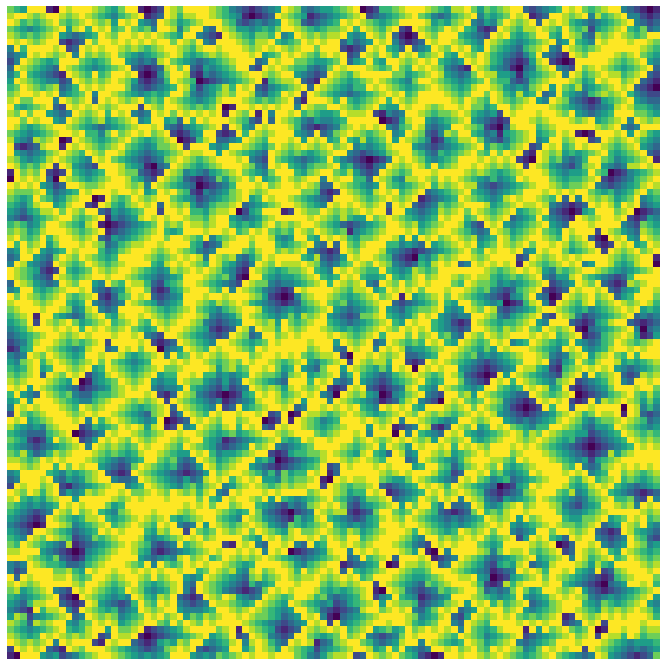

In [27]:
def show_heightmap(hmap):
    M = max(hmap, key=abs)
    W, H = round(M.real)+1, round(M.imag)+1
    raster = [[hmap[complex(x, y)] for x in range(W)] for y in range(H)]
    plt.figure(figsize=(12, 12))
    plt.imshow(raster)
    plt.axis('off')
    plt.show()

show_heightmap(load_heightmap(day(9)))

## Day 10: [Syntax Scoring](https://adventofcode.com/2021/day/10)
The input is a list of lines which contain nested pairs of characters, `(), [], {}, <>`. For part one we must calculate a score for all the syntax errors. 

In [28]:
def error_score(c):
    return -{')': 3, ']': 57, '}': 1197, '>': 25137}[c]

table = str.maketrans(')]}>', '1234')

def autocomplete_score(completion):
    return int(cat(completion).translate(table), 5)
    
def syntax_score(line):
    stack = []
    open_close = dict(zip('([{<', ')]}>'))
    for c in line:
        if c in open_close.keys():
            stack.append(open_close[c])
        elif c in open_close.values():
            if not stack or stack.pop() != c:
                return error_score(c)
    return autocomplete_score(cat(stack[::-1]))

assert syntax_score('{([(<{}[<>[]}>{[]{[(<()>') == -1197

scores = [syntax_score(line) for line in day(10).splitlines()]
sum(-score for score in scores if score < 0)

168417

For part two, we discard syntax errors. If a line is incomplete (i.e. not all opening brackets are closed), we must work out how to complete it and calculate an autocomplete score.

I modified my solution to part one to return the autocomplete score, adjusting `syntax_score` to return a negative score for errors.

In [29]:
assert syntax_score('[({(<(())[]>[[{[]{<()<>>') == 288957
# Autocomplete tools are an odd bunch: the winner is found by sorting all of 
# the scores and then taking the middle score.
# (There will always be an odd number of scores to consider.)
statistics.median(score for score in scores if score > 0)

2802519786

## Day 11: [Dumbo Octopus](https://adventofcode.com/2021/day/11)

There's a 10x10 grid filled with octopuses. An octopus has an energy in the range 0 to 9. At each time step:
- each energy increases by 1
- if an energy exceeds 9, the octopus flashes, which in turn increases the energy of its neighbours by 1, causing them to flash, and so on
- any octopus which flashed has its energy reset to 0

For part one we are asked for the total number of flashes after 100 steps.

In [30]:
example_11 = '''\
5483143223
2745854711
5264556173
6141336146
6357385478
4167524645
2176841721
6882881134
4846848554
5283751526
'''

load_octopuses = load_heightmap

def run_cavern(octopuses):
    while True:
        yield octopuses
        octopuses = {o:e+1 for o, e in octopuses.items()}
        flashers = {o for o, e in octopuses.items() if e > 9}
        flashed = set()
        while flashers:
            f = flashers.pop()
            flashed.add(f)
            for n in neighbours8(f, octopuses) - flashed:
                octopuses[n] += 1
                if octopuses[n] > 9:
                    flashers.add(n)
        octopuses.update((o, 0) for o, e in octopuses.items() if e > 9)

def flashes(octopuses):
    return sum(e == 0 for e in octopuses.values())

def count_flashes(octopus_data, steps=100):
    seq = run_cavern(load_octopuses(octopus_data))
    return sum(flashes(o) for o in its.islice(seq, steps+1))

assert count_flashes(example_11) == 1656
count_flashes(day(11))

1773

Part two asks when all the octopuses flash together.

In [31]:
def all_flash(octopus_data):
    seq = run_cavern(load_octopuses(octopus_data))
    return next(t for t, o in enumerate(seq) if not any(o.values()))

assert all_flash(example_11) == 195
all_flash(day(11))

494

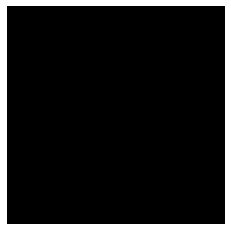

In [32]:
from matplotlib import animation
from IPython.display import HTML

def movie(octopus_data, t=600):
    R = range(10)
    seq = run_cavern(load_octopuses(octopus_data))
    def step():
        o = next(seq)
        return [[o[complex(x, y)] for x in R] for y in R]
    def next_frame(i):
        img.set_data(step())
        return img, # Careful! Must return an iterable
    fig = plt.figure()
    plt.axis('off')
    img = plt.imshow(step(), cmap="binary")
    return animation.FuncAnimation(fig, next_frame, frames=t, interval=100)

animation = movie(day(11))
animation.save("day11.mp4")
HTML(animation.to_jshtml())
# HTML(animation.to_html5_video())

## Day 12: [Passage Pathing](https://adventofcode.com/2021/day/12)
The input is a graph, one edge per line. The nodes are caves, either big (uppercase) or small (lowercase). For part one we are asked to count the number of paths from `start` to `end`, with the rule that a path may visit a big cave any number of times but a small cave at most once.

In [33]:
example_12 = '''\
start-A
start-b
A-c
A-b
b-d
A-end
b-end
'''

def load_caves(cave_data):
    g = cs.defaultdict(set)
    for line in cave_data.splitlines():
        v, _, w = line.partition('-') 
        g[v].add(w)
        g[w].add(v)
    return dict(g)

is_big_cave = str.isupper

def count_paths(caves):
    count = 0
    # pairs record current position and small caves seen 
    paths = [('start', {'start'})]
    while paths:
        where, visited = paths.pop()
        for n in caves[where]:
            if n == 'end':
                count += 1
            elif is_big_cave(n):
                paths.append((n, visited))
            elif n not in visited:
                paths.append((n, visited | {n}))
    return count

assert count_paths(load_caves(example_12)) == 10
count_paths(load_caves(day(12)))

4707

Part two changes the rules. Big caves can be visited any number of times, a single small cave can be visited at most twice, and the remaining small caves can be visited at most once.

In [34]:
def count_paths2(caves):
    count = 0
    # triples record current position, small caves visited, 
    # and whether a small cave has been visited twice
    paths = [('start', {'start'}, False)]
    while paths:
        where, visited, twice = paths.pop()
        for n in caves[where]:
            if n == 'end':
                count += 1
            elif n == 'start':
                pass
            elif is_big_cave(n):
                paths.append((n, visited, twice))
            elif n not in visited:
                paths.append((n, visited | {n}, twice))
            elif not twice:
                paths.append((n, visited, True))
    return count

assert count_paths2(load_caves(example_12)) == 36
count_paths2(load_caves(day(12)))

130493

## Day 13: [Transparent Origami](https://adventofcode.com/2021/day/13)
Instructions here are (x, y) positions of dots on a transparent sheet of origami paper, followed by a list of fold instructions. Part one asks us to count how many dots are visible after following the first fold instruction. Note that if dots are in the same position after folding, count them once.

In [35]:
example_13 = '''\
6,10
0,14
9,10
0,3
10,4
4,11
6,0
6,12
4,1
0,13
10,12
3,4
3,0
8,4
1,10
2,14
8,10
9,0

fold along y=7
fold along x=5
'''

def fold_x(x, y, X):
    return 2*X - x if x > X else x, y

def fold_y(x, y, Y):
    return x, 2*Y - y if y > Y else y

def load_origami(data):
    pts, folds = set(), []
    for line in data.splitlines():
        vs = ints(line)
        if len(vs) == 2:
            pts.add(vs)
        elif len(vs) == 1:
            folds.append((fold_x if 'x' in line else fold_y, vs[0]))
    return pts, folds

def fold_origami(pts, folds):
    for fold, v in folds:
        pts = {fold(*pt, v) for pt in pts}
        yield pts

pts, folds = load_origami(example_13)
folded = fold_origami(pts, folds)
assert len(next(folded)) == 17
assert len(next(folded)) == 16
len(next(fold_origami(*load_origami(day(13)))))

751

Part two asks us to finish folding and read the pattern on the final paper.

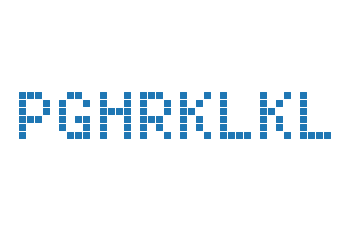

In [36]:
def display_pattern(data):
    pattern = last(fold_origami(*load_origami(data)))
    plt.axis('equal')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.scatter(*transpose(pattern), marker='s')

display_pattern(day(13))

## Day 14: [Extended Polymerisation](https://adventofcode.com/2021/day/14)
A polymer is extended by pair insertion rules. The input consists of the polymer and the rules. For part one we must apply the rules 10 times.

> What do you get if you take the quantity of the most common element and subtract the quantity of the least common element?

In [37]:
example_14 = '''\
NNCB

CH -> B
HH -> N
CB -> H
NH -> C
HB -> C
HC -> B
HN -> C
NN -> C
BH -> H
NC -> B
NB -> B
BN -> B
BB -> N
BC -> B
CC -> N
CN -> C
'''
def get_rule(line):
    x, _, y = line.partition(' -> ')
    return x, y

def load_polymer_rules(data):
    lines = data.splitlines()
    return lines[0], dict(map(get_rule, lines[2:]))

def expand(p, rules):
    return rules[cat(p)], p[1] if cat(p) in rules else p,

def apply_rules(polymer, rules):
    return [
        polymer[0], 
        *list(flatten(expand(p, rules) for p in pairwise(polymer)))]

def grow_polymer(polymer, rules):
    polymer = list(polymer)
    while True:
        yield polymer
        polymer = apply_rules(polymer, rules)

ps = grow_polymer(*load_polymer_rules(example_14))
assert cat(next(ps)) == 'NNCB'
assert cat(next(ps)) == 'NCNBCHB'

In [38]:
def score_part_one(data, steps=10):
    polymer, rules = load_polymer_rules(data)
    grown = nth(grow_polymer(polymer, rules), steps)
    element_counts = cs.Counter(grown).most_common()
    return element_counts[0][1] - element_counts[-1][1]

assert score_part_one(example_14) == 1588
score_part_one(day(14))

2621

For part two, we are asked the same question, but we'll be making 40 steps.
For the example input, the most common element after 40 steps occurs 2192039569602 times.
The approach used will not run quickly enough.

I recoded, using a polymer representation maintaining counts of element pairs. This works since each element pair evolves independently.

In [39]:
def get_rule(line):
    (L, R), _, M = line.partition(' -> ')
    return L+R, (L+M, M+R)

def load_polymer_rules(data):
    lines = data.splitlines()
    return lines[0], dict(map(get_rule, lines[2:]))

def apply_rules(polymer, rules):
    result = cs.Counter()
    for pair, n in polymer.items():
        for split in rules[pair]:
            result[split] += n
    return result

def grow_polymer(polymer, rules):
    polymer = cs.Counter(L+R for L, R in pairwise(polymer))
    while True:
        yield polymer
        polymer = apply_rules(polymer, rules)

def score_polymer(data, steps=10):
    polymer, rules = load_polymer_rules(data)
    grown = nth(grow_polymer(polymer, rules), steps)
    # We now have the frequencies of element pairs, which we can process
    # to find actual element frequencies.
    # Elements have been counted twice, except the very first and last in 
    # the original polymer: fix this by putting them in now.
    elements = cs.Counter(polymer[0] + polymer[-1])
    for pair, n in grown.items():
        for element in pair:
            elements[element] += n
    frequencies = elements.most_common()
    
    return (frequencies[0][1] - frequencies[-1][1])//2

assert score_polymer(example_14, steps=40) == 2188189693529
score_polymer(day(14), steps=40)

2843834241366

## Day 15: [Chiton](https://adventofcode.com/2021/day/15)
The input is a grid of numbers which represent risk levels. We must get from top-left to bottom-right stepping horizontally or vertically in a way which minimises the total risk.

In [40]:
example_15='''\
1163751742
1381373672
2136511328
3694931569
7463417111
1319128137
1359912421
3125421639
1293138521
2311944581
'''

import heapq

def incr(v): return 1 if v == 9 else v+1 

def load_risks(data, side=1):
    g = load_heightmap(data)
    s0 = set(g)
    M = max(g, key=abs)
    W, H = round(M.real)+1, round(M.imag)+1
    for r, c in its.product(range(side), repeat=2):
        if (r, c) == (0, 0): continue
        top = r==0
        prev = (r if top else r-1)*W + (c-1 if top else c)*H*1j
        this = r*W + c*H*1j
        g.update((this+v, incr(g[prev+v])) for v in s0)
    return g

def astar_shortest_path(start, moves, heuristic):
    """ A-star shortest path
    
    - start: initial state
    - moves: state -> (new state, step)*
    - heuristic: state -> estimated distance to goal
    
    Returns the distance to the goal and the path to the goal
    """
    seq = its.count().__next__ # Breaks ties, so no need to order states 
    previous = {start: None}
    distance = {start: 0}
    fringe = [(heuristic(start), seq(), start)]
    def path(p):
        return [] if previous[p] is None else (path(previous[p]) + [p])
    while fringe:
        _, _, p = heapq.heappop(fringe)
        d = distance[p]
        if heuristic(p) == 0:
            return d, path(p)
        for n, s in moves(p):
            if n not in distance or d + s < distance[n]:
                h = heuristic(n) 
                heapq.heappush(fringe, (d + s + h, seq(), n))
                distance[n] = d + s
                previous[n] = p

def least_risk_path_cost(g):
    def moves(p):
        return ((n, g[n]) for n in neighbours4(p, g))
    def heuristic(p):
        d = p - end
        return abs(d.real) + abs(d.imag)
    start, end = min(g, key=abs), max(g, key=abs)
    return astar_shortest_path(start, moves, heuristic)

assert least_risk_path_cost(load_risks(example_15))[0] == 40
least_risk_path_cost(load_risks(day(15)))[0]

824

Part two expands the input:

> The entire cave is actually five times larger in both dimensions than you thought; the area you originally scanned is just one tile in a 5x5 tile area that forms the full map. Your original map tile repeats to the right and downward; each time the tile repeats to the right or downward, all of its risk levels are 1 higher than the tile immediately up or left of it. However, risk levels above 9 wrap back around to 1

I went back and modified the risk loader to accept the number of repeats as a parameter.

In [41]:
assert least_risk_path_cost(load_risks(example_15, 5))[0] == 315
%time least_risk_path_cost(load_risks(day(15), 5))[0]

Wall time: 1.53 s


3063

## Day 16: [Packet Decoder](https://adventofcode.com/2021/day/16)
The input is a sequence of packets represented as a hexadecimal string interpreted as a bitstream.
Each packet has a header:
- 3 bit version
- 3 bit type
  - type 4: literal
  - otherwise: operator

A **literal** is a series of 5 bit chunks. Lead chunks start with a 1. The final chunk starts with a 0. The embedded nybbles give a binary value.

An **operator** starts with a 1-bit length type:
- 0, the next 15 bits give the length in bits of the sub-packets
- 1, the next 11 bits give the number of sub-packets

The subpackets then follow.

Part one asks us to add up the version numbers of all packets.

In [42]:
Packet = cs.namedtuple(
    'Packet', 'version typ payload') # payload is a literal or a list of Packets

def val(s):
    "Return the numeric value of binary string `s`"
    return int(s, base=2)

def decode_header(bits):
    "Given a bitstream, return the header fields and the remaining bits"
    return val(bits[:3]), val(bits[3:6]), bits[6:]

def decode_literal(bits):
    "Given a bitstream, return the literal value and the remaining bits"
    s = ''
    while True:
        lead, chunk, bits = bits[:1], bits[1:5], bits[5:]
        s += chunk
        if lead == '0': return val(s), bits

def decode_packet(bits):
    "Given a bitstream, return the packet and the remaining bits"
    version, typ, bits = decode_header(bits)
    if typ == 4:
        payload, bits = decode_literal(bits)
    else:
        lentyp, bits = bits[:1], bits[1:]
        payload = []
        if lentyp == '0':
            subs_len, bits = val(bits[:15]), bits[15:]
            len_left = len(bits) - subs_len
            while len(bits) != len_left:
                packet, bits = decode_packet(bits)
                payload.append(packet)
        else:
            n_subs, bits = val(bits[:11]), bits[11:]
            for _ in range(n_subs):
                packet, bits = decode_packet(bits)
                payload.append(packet)
    return Packet(version, typ, payload), bits

def bitstream(hexstream):
    bits = bin(int(hexstream, base=16))[2:] # chop leading '0b'
    return '0000'[:-len(bits)%4] + bits # pad length to be a multiple of 4

def version_sum(hexstream):
    def vsum(p):
        return (p.version + (sum(vsum(p) for p in p.payload) 
                if isinstance(p.payload, list) else 0))
    return vsum(decode_packet(bitstream(hexstream))[0])

assert version_sum('A0016C880162017C3686B18A3D4780') == 31
version_sum(day(16))

957

Part two tells us what the operator types are and asks us to calculate the value of a bitstream.

In [43]:
typ_to_op = {0: sum, 1: math.prod, 2: min, 3: max}
typ_to_binop = {5: ops.gt, 6: ops.lt, 7: ops.eq}

def calculate(hexstream):
    def calc(p):
        _, typ, payload = p
        if typ == 4:
            return payload
        elif typ in typ_to_op: 
            return typ_to_op[typ](map(calc, payload))
        else: 
            return typ_to_binop[typ](*map(calc, payload))
    return calc(decode_packet(bitstream(hexstream))[0])

calculate(day(16))

744953223228

## Day 17: [Trick Shot](https://adventofcode.com/2021/day/17)
A launcher can fire a probe with integer valued x and y velocity.
The probe:
- starts at 0, 0
- then advances in steps
- at each step the x velocity decreases by 1 toward 0
- the y velocity decreases by 1

The probe is aimed at a target area, which is our puzzle input:

   x=253..280, y=-73..-46

For part one, we must find how high the probe can go and still hit the target.

-----

Inspecting the rules, we can imagine the probe firing upwards then decelerating as if gravity is 1.

To maximimise the height we maximise `vy`, the initial y velocity.

The y-steps taken go up and then down: `vy, vy-1, ... , -vy+1, -vy, -vy-1`.

The x-steps go down to zero: `vx, vx-1, ..., 1`.

The step of `-vy` takes us to `y = 0`. The next step is the one which must be within the target area.

So to maximise `vy` we have `-vy-1 = -73`, so `vy = 72` and the maximum height is 72+71+...+1, which is 2628.

To show this is acheivable we must confirm there's a solution to `vx + vx-1 + ... 1` in `253..280`.

Values of `vx` of `22` or `23` work here. 

In [44]:
(72 * 73)/2

2628.0

In [45]:
math.sqrt(280*2)

23.664319132398465

In [46]:
(22*23)/2, (23*24)/2 

(253.0, 276.0)

Part two asks for the number of initial velocities which result in a hit. I used brute force.

In [47]:
def is_hit(vx, vy):
    vxs = its.chain(range(vx, -1, -1), its.repeat(0))
    vys = its.count(vy, -1)
    for x, y in zip(its.accumulate(vxs), its.accumulate(vys)):
        if x in range(253, 281) and y in range(-73, -45):
            return True
        if y < -73 or x > 281: return False

sum(is_hit(vx, vy) for vx in range(22, 281) for vy in range(72, -75, -1))

1334

## Day 18: [Snailfish](https://adventofcode.com/2021/day/18)
Snailfish numbers are pairs, `[x, y]` where `x` and `y` are integers or snailifish numbers, recursively. To add two snailfish numbers, `s1` and `s2`, combine them into a new pair `[s1, s2]`, then _reduce_ the result by repeatedly applying the first action below which applies:
- If any pair is nested inside four pairs, the leftmost such pair explodes.
- If any regular number is 10 or greater, the leftmost such regular number splits.

In [48]:
def visit(s, depth=0, loc=None):
    """ Visit a snailfish number
    
    Returns a list of (depth, location, value) triples
    """
    if loc is None: loc = []
    result = [(depth, loc, s)]
    if isinstance(s, list):
        result += visit(s[0], depth+1, loc + [0]) + visit(s[1], depth+1, loc + [1])
    return result

visit([7,[6,[5,[4,[3,2]]]]])

[(0, [], [7, [6, [5, [4, [3, 2]]]]]),
 (1, [0], 7),
 (1, [1], [6, [5, [4, [3, 2]]]]),
 (2, [1, 0], 6),
 (2, [1, 1], [5, [4, [3, 2]]]),
 (3, [1, 1, 0], 5),
 (3, [1, 1, 1], [4, [3, 2]]),
 (4, [1, 1, 1, 0], 4),
 (4, [1, 1, 1, 1], [3, 2]),
 (5, [1, 1, 1, 1, 0], 3),
 (5, [1, 1, 1, 1, 1], 2)]

In [49]:
def set_fish(s, loc, v):
    "Set `s` at the nested index location `loc` to `v`"
    for i in loc[:-1]: s = s[i]
    s[loc[-1]] = v

def explode(s):
    "Explode the snailfish number"
    xs = visit(s)
    i = next((i for i, (d, loc, p) in enumerate(xs)
              if d==4 and isinstance(p, list)), None)
    if i is not None:
        l, r = xs[i][2]
        for _, loc, p in xs[i-1::-1]:
            if isinstance(p, int):
                set_fish(s, loc, l + p)
                break
        for _, loc, p in xs[i+3:]:
            if isinstance(p, int):
                set_fish(s, loc, r + p)
                break
        set_fish(s, xs[i][1], 0)
        return s

def split(s):
    "Split the snailfish number"
    xs = visit(s)
    for id, loc, p in xs:
        if isinstance(p, int) and p > 9:
            set_fish(s, loc, [p//2, (p+1)//2])
            return s

def snailfish_add(s, t):
    "Add and reduce two snailfish numbers"
    r = [copy.deepcopy(s), copy.deepcopy(t)]
    while explode(r) or split(r): pass
    return r

def snailfish_sum(xs):
    "Sum a list of snailfish numbers"
    return functools.reduce(snailfish_add, xs[1:], xs[0])

def magnitude(s):
    "Return the magnitude of a snailfish number"
    return s if isinstance(s, int) else 3*magnitude(s[0]) + 2*magnitude(s[1])

assert explode([[[[[9,8],1],2],3],4]) == [[[[0,9],2],3],4]
assert explode([[3,[2,[1,[7,3]]]],[6,[5,[4,[3,2]]]]]) == [[3,[2,[8,0]]],[9,[5,[4,[3,2]]]]]
assert explode([[3,[2,[8,0]]],[9,[5,[4,[3,2]]]]]) == [[3,[2,[8,0]]],[9,[5,[7,0]]]]

example_18 = [
[[[0,[4,5]],[0,0]],[[[4,5],[2,6]],[9,5]]],
[7,[[[3,7],[4,3]],[[6,3],[8,8]]]],
[[2,[[0,8],[3,4]]],[[[6,7],1],[7,[1,6]]]],
[[[[2,4],7],[6,[0,5]]],[[[6,8],[2,8]],[[2,1],[4,5]]]],
[7,[5,[[3,8],[1,4]]]],
[[2,[2,2]],[8,[8,1]]],
[2,9],
[1,[[[9,3],9],[[9,0],[0,7]]]],
[[[5,[7,4]],7],1],
[[[[4,2],2],6],[8,7]]
]
assert snailfish_sum(example_18) == [[[[8,7],[7,7]],[[8,6],[7,7]]],[[[0,7],[6,6]],[8,7]]]

For part one we are asked to calculate the magnitude of the sum of a list of snailfish numbers.

In [50]:
day18 = [eval(s) for s in day(18).splitlines()]
magnitude(snailfish_sum(day18))

4641

Part two asks for the largest magnitude of the sum of any pair drawn from the list, noting that addition is not commutative.

In [51]:
max(magnitude(snailfish_add(*p)) for p in its.permutations(day18, 2))

4624

## Day 19: [Beacon Scanner](https://adventofcode.com/2021/day/19)

This puzzle sets scanners and beacons in 3D space.

Each scanner reports the list of beacons it detects. Note:

1. scanners have a limited range (1000 along each axis direction)
2. scanners do not know their rotation or facing direction

We must reconstruct the beacons. We are told:

> The scanners and beacons map a single contiguous 3d region. This region can be reconstructed by finding pairs of scanners that have overlapping detection regions such that there are at least 12 beacons that both scanners detect within the overlap. By establishing 12 common beacons, you can precisely determine where the scanners are relative to each other, allowing you to reconstruct the beacon map one scanner at a time.

In [52]:
def matmul(mx):
    "Return the product of the supplied matrices"
    return functools.reduce(ops.matmul, mx, np.identity(3))

def transforms():
    "Return the set of orthogonal transforms around X, Y, Z axes"
    rx = np.array([[1, 0,  0],
                   [0, 0, -1],
                   [0, 1,  0]], dtype=int)
    ry = np.array([[0, 0, -1],
                   [0, 1,  0],
                   [1, 0,  0]], dtype=int)
    rz = np.array([[0, -1, 0],
                   [1, 0,  0 ],
                   [0, 0,  1]], dtype=int)
    tfs = {}
    for tx, ty, tz in its.product(range(4), repeat=3):
        tf = matmul(its.chain([rx]*tx, [ry]*ty, [rz]*tz))
        tfs[tuple(flatten(tf))] = tf
    return list(tfs.values())

def load_scans(data):
    "Load the input scans"
    scans = []
    for line in data.splitlines():
        if 'scanner' in line:
            scans.append([])
        elif line.strip():
            scans[-1].append(np.fromstring(line, sep=',', dtype=int))
    return scans

xforms = transforms()
scans=load_scans(day(19))
cs.Counter(len(s) for s in scans)

Counter({26: 25, 25: 10})

So, we have 35 scanners each of which scans 25 or 26 beacons.

In [53]:
def do_intersect(xforms, scan_a, scan_b):
    scan_a = [np.array(a, dtype=int) for a in scan_a]
    for a in scan_a:
        a_diffs = {tuple(a-A) for A in scan_a}
        for b in scan_b:
            for xf in xforms:
                b_diffs = {tuple(xf.dot(b-B)) for B in scan_b}
                common = a_diffs & b_diffs
                if len(common) >= 12:
                    return xf, a, b

def move_scan(scan, xf, a, b):
    d = a - np.linalg.inv(np.transpose(xf)).dot(b)
    return d, [np.array(d + xf.dot(p), dtype=int) for p in scan]

scans = load_scans(open('input/example19').read())
xf, a, b = do_intersect(xforms, scans[0], scans[1]) # a and b are the same point
move_scan(scans[1], xf, a, b)

(array([   68., -1246.,   -43.]),
 [array([-618, -824, -621]),
  array([-537, -823, -458]),
  array([-447, -329,  318]),
  array([ 404, -588, -901]),
  array([  -27, -1108,   -65]),
  array([ 544, -627, -890]),
  array([  408, -1815,   803]),
  array([ -499, -1607,  -770]),
  array([ 528, -643,  409]),
  array([ -601, -1648,  -643]),
  array([-661, -816, -575]),
  array([  568, -2007,  -577]),
  array([ 390, -675, -793]),
  array([  534, -1912,   768]),
  array([  497, -1838,  -617]),
  array([ 423, -701,  434]),
  array([ -635, -1737,   486]),
  array([  396, -1931,  -563]),
  array([-345, -311,  381]),
  array([ 459, -707,  401]),
  array([ -518, -1681,  -600]),
  array([  432, -2009,   850]),
  array([ -739, -1745,   668]),
  array([ -687, -1600,   576]),
  array([-485, -357,  347])])

In [54]:
def find_beacons(scans, xforms):
    beacons = {tuple(b) for b in scans[0]}
    queue = scans[1:]
    scanners = []
    
    while queue:
        scan = queue.pop(0)
        if v:= do_intersect(xforms, beacons, scan):
            scanner, moved = move_scan(scan, *v)
            scanners.append(scanner)
            beacons |= {tuple(b) for b in moved}
        else:
            queue.append(scan)

    return scanners, beacons

def scanner_separation(scanners):
    return max(np.sum(np.abs(p-q)) 
               for p, q in its.combinations(scanners, 2))

scanners, beacons = find_beacons(load_scans(open('input/example19').read()), xforms)
assert len(beacons) == 79
assert scanner_separation(scanners) == 3621
%time scanners, beacons = find_beacons(load_scans(day(19)), xforms)
len(beacons), scanner_separation(scanners)

Wall time: 4min 6s


(432, 14414.0)

## Day 20: [Trench Map](https://adventofcode.com/2021/day/20)
The input consists of an image enhancement algorithm and an image. For part one we are asked to apply the algorithm twice.

In [55]:
def load_trenchmap(lines):
    return {
        r*1j + c: p=='#'
        for r, row in enumerate(lines)
        for c, p in enumerate(row)}

def load_converter(s):
    assert len(s) == 512
    return [c=='#' for c in s]

def load_day20(data):
    lines = data.splitlines()
    return load_trenchmap(lines[2:]), load_converter(lines[0])

def block3x3(p):
    return [p-1-1j, p-1j, p+1-1j,
            p-1,    p,    p+1,  
            p-1+1j, p+1j, p+1+1j]

def enhance_pixel(im, p, converter, border):
    code = functools.reduce(
        lambda t, n: t<<1 | im.get(n, border), block3x3(p), 0)
    return converter[code]

def extend(r, d=2):
    return range(r.start - d, r.stop + d)

def enhance_image(im, converter):
    tl, br = min(im, key=abs), max(im, key=abs)
    xx = range(int(tl.real), int(br.real) + 1)
    yy = range(int(tl.imag), int(br.imag) + 1)
    borders = (0, 1) if converter[0] else (0,)
    for border in its.cycle(borders):
        yield im
        xx, yy = extend(xx), extend(yy)
        im = {p: enhance_pixel(im, p, converter, border)
              for p in its.starmap(complex, its.product(xx, yy))}

example_20 = '''\
..#.#..#####.#.#.#.###.##.....###.##.#..###.####..#####..#....#..#..##..###..######.###...####..#..#####..##..#.#####...##.#.#..#.##..#.#......#.###.######.###.####...#.##.##..#..#..#####.....#.#....###..#.##......#.....#..#..#..##..#...##.######.####.####.#.#...#.......#..#.#.#...####.##.#......#..#...##.#.##..#...##.#.##..###.#......#.#.......#.#.#.####.###.##...#.....####.#..#..#.##.#....##..#.####....##...##..#...#......#.#.......#.......##..####..#...#.#.#...##..#.#..###..#####........#..####......#..#

#..#.
#....
##..#
..#..
..###
'''

ims = enhance_image(*load_day20(example_20))
assert sum(nth(ims, 2).values()) == 35
ims = enhance_image(*load_day20(day(20)))
sum(nth(ims, 2).values())

5680

Ha, the image is infinite! An outer pixel starts dark surrounded by dark neighbours, giving a binary number of `000000000`. Inspecting our input shows that this corresponds to a `#`. So the entire border of the image is lit after one step. In this border, light pixels surrounded by light neighbours give a binary value of `111111111`. This corresponds to a `.`.

So, for our actual input the infinite border toggles between light and dark.

My initial attempt failed to account for this. I revised the code to include the border colour.

Part two asks how many pixels are lit after 50 repetitions.

In [56]:
ims = enhance_image(*load_day20(day(20)))
%time sum(nth(ims, 50).values())

Wall time: 7.44 s


19766

## Day 21: [Dirac Dice](https://adventofcode.com/2021/day/21)
The game:
- a 100-sided die
- two pawns starting at random positions (the puzzle input)
- a board with squares 1..10

The dice is _deterministic_, and rolls cycle through 1..100.
Players take turns, rolling the die three times, advancing by the total of the three numbers, then scoring the square they end up on. The game is won when a player reaches 1000, and we're asked for the product of the lower score and the number of times the die has been rolled.

In [57]:
def deterministic_dice(start_a, start_b, limit=1000):
    scores = [0, 0]
    positions = [start_a-1, start_b-1]
    die = its.cycle(range(1, 101))
    turns = zip(*[die]*3)
    for turn, rolls, player in zip(turns, its.count(3, 3), its.cycle((0, 1))):
        step = sum(turn)
        positions[player] = (positions[player] + step) % 10
        scores[player] += positions[player] + 1
        if scores[player] >= limit:
            return scores[not player] * rolls

assert deterministic_dice(4, 8) == 739785
# My inputs:
# Player 1 starting position: 3
# Player 2 starting position: 7
deterministic_dice(3, 7)

1006866

Part two uses a 3-sided Dirac die. After each roll the universe splits into 3 copies, where the rolls were 1, 2, 3 respectively. For this new game, we'll end whenever a player's score reaches 21.
We are asked for the number of universes the most winning player triumphs in.

In [58]:
def dirac_dice(start_a, start_b, limit=21):
    steps = cs.Counter(map(sum, its.product((1, 2, 3), repeat=3)))
    @functools.lru_cache(None)
    def play(a, b):
        winsa, winsb = 0, 0
        for step, count in steps.items():
            pos, score = a
            pos = (pos + step) % 10
            score += pos + 1
            if score >= limit:
                winsa += count
            else:
                wb, wa = play(b, (pos, score))
                winsa += count * wa
                winsb += count * wb
        return winsa, winsb
    return play((start_a-1, 0), (start_b-1, 0))

assert dirac_dice(4, 8) == (444356092776315, 341960390180808)
%time max(dirac_dice(3, 7))

Wall time: 53 ms


273042027784929

## Day 22: [Reactor Reboot](https://adventofcode.com/2021/day/22)
We have a series of instructions to turn cuboid regions of cells on and off. E.g.

    on x=10..12,y=10..12,z=10..12
    on x=11..13,y=11..13,z=11..13
    off x=9..11,y=9..11,z=9..11
    on x=10..10,y=10..10,z=10..10

For part one we must count how many cells are on at the end of the sequence, _considering only cells in the region x=-50..50,y=-50..50,z=-50..50_.

In [59]:
def intersect_ranges(r, s):
    return range(max(r.start, s.start), min(r.stop, s.stop))

def intersect_cuboids(xyz, XYZ):
    return [intersect_ranges(*p) for p in zip(xyz, XYZ)]

def nonempty_cuboid(cuboid):
    return all(c for c in cuboid)

def count_cells(instructions):
    cells = set()
    def limit(r, R):
        return intersect_ranges(range(r, R+1), range(-50, 51))
    for instruction in instructions.splitlines():
        x, X, y, Y, z, Z = ints(instruction)
        these_cells = set(its.product(limit(x, X), limit(y, Y), limit(z, Z)))
        if instruction.startswith("on" ): cells |= these_cells
        if instruction.startswith("off"): cells -= these_cells
    return len(cells)

assert count_cells(open("input/example22").read()) == 590784
count_cells(day(22))

583641

Part two required a different strategy.
To track the number of cells which are on or off, we track intersections between the instructions.

The important axioms are:
- `|A ∪ B| = |A| + |B| - |A ∩ B|`
- `|A - B| = |A| - |A ∩ B|`

In [60]:
def volume(cuboid):
    return math.prod(len(r) for r in cuboid)
    
def count_cells(instructions):
    cuboids = [] # A list of regions, (onoff=-1,1, rangeX, rangeY, rangeZ)
    for line in instructions.splitlines():
        x, X, y, Y, z, Z = ints(line)
        this_cuboid = range(x,X+1), range(y,Y+1), range(z,Z+1)
        
        updates = [(1, this_cuboid)] if line.startswith('on') else []
        updates.extend(
            (-onoff, overlap) for onoff, cuboid in cuboids
            if volume(overlap := intersect_cuboids(cuboid, this_cuboid)))
        cuboids.extend(updates)

    return sum(onoff * volume(cuboid) for onoff, cuboid in cuboids)

assert count_cells(open("input/example22_part2").read()) == 2758514936282235
%time count_cells(day(22))

Wall time: 25.7 s


1182153534186233

## Day 23: [Amphipod](https://adventofcode.com/2021/day/23)
There are 4 types of amphipod, `A`, `B`, `C`, `D`. We have a diagram showing their locations along with walls `#` and open space `.`. The diagram shows a hallway and four side rooms, and we want to move the amphipods so each side room contains one sort of amphipod.

Amphipods move step by step in the axis directions, and the costs of each step are 1, 10, 100 and 1000 for the A, B, C, D types. The objective is to organise the amphipods into side rooms by type as shown, minimising the cost.

```
#############
#...........#
###A#B#C#D###
  #A#B#C#D#
  #########
```

Rules for moving amphipods:
1. amphipods will never stop on the space immediately outside any room
2. amphipods will never move from the hallway into a room unless that room is a) their destination room and b) contains no amphipods which do not also have that room as their own destination
3. once an amphipod stops moving in the hallway, it will stay in that spot until it can move into a room

In [61]:
# We model the positions as complex numbers, with the hallway being the real axis
# Note that positions 2, 4, 6, 8 can not be used (Rule 1)
# The side rooms are 2+1j, 4+1j ...
hallway = {0, 1, 3, 5, 7, 9, 10}
amphipod_cost = {'A': 1, 'B': 10, 'C': 100, 'D': 1000}
amphipod_dest = {'A': 2, 'B': 4, 'C': 6, 'D': 8}

def heuristic(s):
    "A lower-bound estimate on the cost remaining at a state"
    return sum(amphipod_cost[a]*abs(p.real - amphipod_dest[a])
               for a, p in s)

def route(p, q):
    "Generate the positions visited moving from p to q"
    while p.imag != 0: 
        p -= 1j
        yield p
    d = 1 if p.real < q.real else -1
    while p.real != q.real:
        p += d
        yield p
    while p.imag != q.imag: 
        p += 1j
        yield p

def distance(p, q):
    "Return the distance travelled from p to q"
    return abs(p.real - q.real) + p.imag + q.imag

def moves(state):
    "Generate the possible moves with costs from a state"
    where = {p: a for a, p in state} 
    depth = round(max(p.imag for p in where))

    def finished(x):
        "Return the list of type x amphipods which have finished"
        dest = amphipod_dest[x]
        ps = (dest + d*1j for d in range(depth, 0, -1))
        return list(its.takewhile(lambda p: where.get(p)==x, ps))

    def can_move(p, q):
        "Return True if the amphipod at p can move to q, else False"
        return not any(s in where for s in route(p, q))
    
    def to_hall(p):
        return (h for h in hallway if can_move(p, h))

    def to_dest(a, p):
        dest = amphipod_dest[a]
        at_dest = finished(a)
        d = dest + (depth - len(at_dest))*1j
        if can_move(p, d): yield d

    def step(x, p, n):
        "Return the state, cost after moving amphipod type x from p to n"
        s = tuple([(a, q) for (a, q) in state if q != p] + [(x, n)])
        return s, distance(p, n) * amphipod_cost[x]

    for a, p in state:
        if p in finished(a): steps = ()
        elif p in hallway: steps = to_dest(a, p)
        else: steps = to_hall(p)
        yield from (step(a, p, s) for s in steps)

example_23 = '''\
#############
#...........#
###B#C#B#D###
  #A#D#C#A#
  #########
'''

day_23 = '''\
#############
#...........#
###C#C#A#B###
  #D#D#B#A#
  #########
'''

def load_amphipods(data):
    rooms = (complex(c, r) for r, c in 
             its.product(range(1, 6), range(2, 10, 2)))
    types = [x for x in data if x in 'ABCD']
    return tuple(zip(types, rooms))

assert astar_shortest_path(load_amphipods(example_23), moves, heuristic)[0] == 12521
%time astar_shortest_path(load_amphipods(day_23), moves, heuristic)[0]

Wall time: 58.4 s


18282.0

Part two tells us the input is incomplete, and the lines:
```
#D#C#B#A#
#D#B#A#C#
```
should be inserted into the intial configuration.
Most of my code already handled this. I adjusted the load and the finished functions to handle the depth.

In [62]:
example_23 = '''\
#############
#...........#
###B#C#B#D###
  #D#C#B#A#
  #D#B#A#C#
  #A#D#C#A#
  #########
'''
day_23 = '''\
#############
#...........#
###C#C#A#B###
  #D#C#B#A#
  #D#B#A#C#
  #D#D#B#A#
  #########
'''

assert astar_shortest_path(load_amphipods(example_23), moves, heuristic)[0] == 44169
%time astar_shortest_path(load_amphipods(day_23), moves, heuristic)[0]

Wall time: 3min 11s


50132.0

## Day 24: [Arithmetic Logic Unit](https://adventofcode.com/2021/day/24)
The ALU supports six instructions:
- `inp a` read input value and write to `a`
- `op a b` store the result of applying `op` to `a`, `b` in `a`. Op can be `mul`, `div`, `mod`, `eql`
Here, `a` will be a register `w`, `x`, `y` or `z`, and `b` will be a number or a register.

A fourteen-digit model number is valid if, after running the code sample through the ALU, the register `z` is set to `0`. Note that the digit `0` cannot be in a model number. 
So, there are `9**14` possible model numbers! That's ~23 trillion.

Running the code for every model number isn't going to be quick enough.

Inspecting the code, we can see a repeating pattern every 18 lines.

In [63]:
!split --lines=18 input/24 input/24
!cat input/24aa

inp w
mul x 0
add x z
mod x 26
div z 1
add x 10
eql x w
eql x 0
mul y 0
add y 25
mul y x
add y 1
mul z y
mul y 0
add y w
add y 10
mul y x
add z y


In [64]:
!diff input/24aa input/24ab

6c6
< add x 10
---
> add x 13
16c16
< add y 10
---
> add y 5


In [65]:
!diff input/24aa input/24ad

5,6c5,6
< div z 1
< add x 10
---
> div z 26
> add x -12
16c16
< add y 10
---
> add y 12


So, we have an 18 line subroutine which is called 14 times. Each time we read a digit from the model number into `w` and we change `z`, using local variables `x` and `y`. The lines which vary are the `div z N`, `add x N` and `add y N` lines.

In [66]:
fields = [atoms(line) for line in day(24).splitlines()]
divz = [f[2] for f in fields[4::18]]
addx = [f[2] for f in fields[5::18]]
addy = [f[2] for f in fields[15::18]]

In [67]:
# Each block of 18 lines has the pattern:

# inp w
# mul x 0
# add x z
# mod x 26
# div z {divz}
# add x {addx}
# eql x w
# eql x 0
# mul y 0
# add y 25
# mul y x
# add y 1
# mul z y
# mul y 0
# add y w
# add y {addy}
# mul y x
# add z y

# This is equivalent to a subroutine which reads an input digit w
# takes z as a parameter, and outputs a new value of z.
def subroutine(w, z, divz, addx, addy): # inp w
    x = int(z % 26 + addx != w) # 0 or 1
    z //= divz                  # divz is 1 or 26
    z *= 25*x + 1               # multiplier is 26 or 1
    z += (w + addy)*x           # increment by 0 or w + addy
    return z

In [70]:
import z3

def solve(divz, addx, addy, do_max=True):
    solver = z3.Optimize()
    N = len(divz)
    ws = [z3.Int(f'w{i}') for i in range(N)]
    z = 0
    for w, dz, ax, ay in zip(ws, divz, addx, addy):
        solver.add([w > 0, w < 10])
        x = (z % 26 + ax != w)
        z = (z / dz) * (25 * x + 1) + (w + ay) * x
    
    solver.add(z == 0)

    n = sum(w * 10**p for p, w in enumerate(reversed(ws)))

    (solver.maximize if do_max else solver.minimize)(n)
    assert solver.check() == z3.sat
    return solver.model().eval(n)

fields = [atoms(line) for line in day(24).splitlines()]
divz = [f[2] for f in fields[4::18]]
addx = [f[2] for f in fields[5::18]]
addy = [f[2] for f in fields[15::18]]

%time solve(divz, addx, addy), solve(divz, addx, addy, do_max=False)

Wall time: 30.8 s


(99995969919326, 48111514719111)

## Day 25: [Sea Cucumber](https://adventofcode.com/2021/day/25)
There are two types of sea cucumbers: ones which move east `>` and ones which move south `v`.

They start in a grid pattern, e.g.
```
v...>>.vv>
.vv>>.vv..
>>.>v>...v
>>v>>.>.v.
v>v.vv.v..
>.>>..v...
.vv..>.>v.
v.v..>>v.v
....v..v.>
```
At each step, all east facing sea cucumbers move, then all south facing ones. A sea cucumber moves only if the space it would move to is vacant.

The grid wraps around. We are asked to find the first step on which no sea cucumbers move.

In [69]:
example_25 = '''\
v...>>.vv>
.vv>>.vv..
>>.>v>...v
>>v>>.>.v.
v>v.vv.v..
>.>>..v...
.vv..>.>v.
v.v..>>v.v
....v..v.>
'''
def sea_cucumbers(face_E, face_S):
    br = max(face_E | face_S, key=abs)
    W, H = round(br.real), round(br.imag)

    def hwrap(p): return 1j * p.imag if p.real > W else p  
    def vwrap(p): return p.real if p.imag > H else p
    def vacant(p): return p not in face_E and p not in face_S

    for step in its.count(1):
        move_E = {p for p in face_E if vacant(hwrap(p+1))}
        face_E = {hwrap(p+1) for p in move_E} | (face_E - move_E)
        move_S = {p for p in face_S if vacant(vwrap(p+1j))}
        face_S = {vwrap(p+1j) for p in move_S} | (face_S - move_S)
        if len(move_E) + len(move_S) == 0:
            return step

def load_sea_cucumbers(data):
    cukes = [(complex(c, r), ch)
             for r, row in enumerate(data.splitlines())
             for c, ch in enumerate(row)]
    face_E = {e for e, ch in cukes if ch=='>'}
    face_S = {s for s, ch in cukes if ch=='v'}
    return face_E, face_S

assert sea_cucumbers(*load_sea_cucumbers(example_25)) == 58
%time sea_cucumbers(*load_sea_cucumbers(day(25)))

Wall time: 1.57 s


329